In [69]:
import numpy as np

def forward_euler_step(h, x, y, vx, vy, masses, eps = 1e-3):
    G = 1  # Gravitational constant
    
    # add noise each step to see if the controller can figure out
    x += eps * np.random.rand(3)
    y += eps * np.random.rand(3)

    # Compute center of mass and total momentum
    cm = np.sum(x * masses) / np.sum(masses), np.sum(y * masses) / np.sum(masses)
    p = np.sum(masses.reshape((3,1)) * np.vstack((vx, vy)).T, axis=0)
    
    # Subtract center of mass and total momentum
    x -= cm[0]
    y -= cm[1]
    vx -= p[0] / np.sum(masses)
    vy -= p[1] / np.sum(masses)

    # Compute distances
    r12 = np.sqrt((x[0] - x[1])**2 + (y[0] - y[1])**2)
    r13 = np.sqrt((x[0] - x[2])**2 + (y[0] - y[2])**2)
    r23 = np.sqrt((x[1] - x[2])**2 + (y[1] - y[2])**2)
    
    # Compute accelerations
    ax = np.zeros(3)
    ay = np.zeros(3)
    ax[0] = G * (masses[1] * (x[1] - x[0]) / r12**3 + masses[2] * (x[2] - x[0]) / r13**3)
    ay[0] = G * (masses[1] * (y[1] - y[0]) / r12**3 + masses[2] * (y[2] - y[0]) / r13**3)
    ax[1] = G * (masses[0] * (x[0] - x[1]) / r12**3 + masses[2] * (x[2] - x[1]) / r23**3)
    ay[1] = G * (masses[0] * (y[0] - y[1]) / r12**3 + masses[2] * (y[2] - y[1]) / r23**3)
    ax[2] = G * (masses[0] * (x[0] - x[2]) / r13**3 + masses[1] * (x[1] - x[2]) / r23**3)
    ay[2] = G * (masses[0] * (y[0] - y[2]) / r13**3 + masses[1] * (y[1] - y[2]) / r23**3)

    # Update positions and velocities
    x += h * vx
    y += h * vy
    vx += h * ax
    vy += h * ay
    
    return x, y, vx, vy, ax, ay


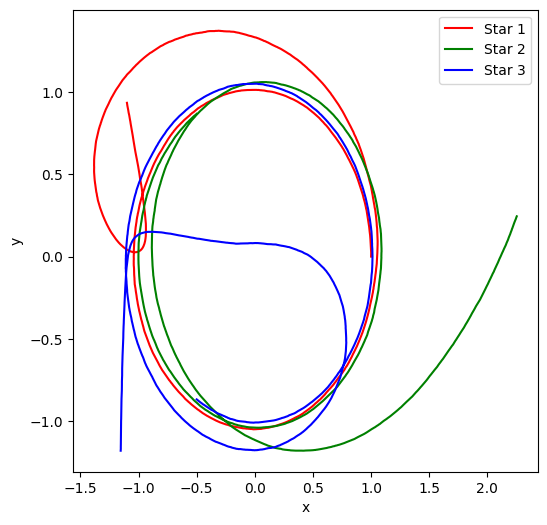

In [71]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Define the initial conditions
h = 0.003
t = 0.0
x = np.array([1, -0.5, -0.5])
y = np.array([0, math.sqrt(3)/2, -math.sqrt(3)/2])
v = np.sqrt(1 / np.sqrt(3))
vx = np.zeros(3)
vy = np.zeros(3)
vx[0] = 0
vy[0] = v
vx[1] = -math.sqrt(3) / 2 * v
vx[2] = math.sqrt(3) / 2 * v
vy[1] = -0.5 * v
vy[2] = -0.5 * v
masses = np.array([1.0, 1.0, 1.0])

# Define the number of time steps to simulate
num_steps = 5000

# Define a list to store the positions of the stars
pos = np.zeros((num_steps+1, 3, 2))
pos[0,:,0] = x
pos[0,:,1] = y

# Simulate the system and store the positions of the stars
for step in range(num_steps):
    x, y, vx, vy, _, _ = forward_euler_step(h, x, y, vx, vy, masses)
    pos[step+1,:,0] = x
    pos[step+1,:,1] = y

# Plot the trajectories of the stars
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(pos[:,0,0], pos[:,0,1], 'r', label='Star 1')
plt.plot(pos[:,1,0], pos[:,1,1], 'g', label='Star 2')
plt.plot(pos[:,2,0], pos[:,2,1], 'b', label='Star 3')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 300)
        self.l2 = nn.Linear(300, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        # a = F.relu(self.l2(a))
        a = torch.sigmoid(self.l3(a)) * self.max_action
        return a


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, 300)
        self.l2 = nn.Linear(300, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, state, action):
        q = F.relu(self.l1(torch.cat([state, action], 1)))
        # q = F.relu(self.l2(q))
        return self.l3(q)


In [73]:
class DDPG(object):
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
        
        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
        
        self.max_action = max_action

    def select_action(self, state):
        state = torch.Tensor(state.reshape(1, -1))
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, iterations, batch_size=64, discount=0.999, tau=0.005):
        for it in range(iterations):
            # Sample replay buffer
            x, y, u, r, d = replay_buffer.sample(batch_size)
            state = torch.Tensor(x)
            action = torch.Tensor(u)
            next_state = torch.Tensor(y)
            done = torch.Tensor(1 - d)
            reward = torch.Tensor(r)

            # Compute the target Q value
            target_Q = self.critic_target(next_state, self.actor_target(next_state))
            target_Q = reward + (done * discount * target_Q).detach()

            # Get current Q estimate
            current_Q = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss
            actor_loss = -self.critic(state, self.actor(state)).mean()

            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


In [74]:
class ReplayBuffer(object):
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, transition):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = transition
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(transition)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
        for i in ind: 
            state, next_state, action, reward, done = self.storage[i]
            batch_states.append(np.array(state, copy=False))
            batch_next_states.append(np.array(next_state, copy=False))
            batch_actions.append(np.array(action, copy=False))
            batch_rewards.append(np.array(reward, copy=False))
            batch_dones.append(np.array(done, copy=False))
        return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)


In [75]:
### environment wrapper functions

def reset_environment():
    x = np.array([1, -0.5, -0.5])
    y = np.array([0, math.sqrt(3)/2, -math.sqrt(3)/2])
    v = np.sqrt(1 / np.sqrt(3))
    vx = np.zeros(3)
    vy = np.zeros(3)
    vx[0] = 0
    vy[0] = v
    vx[1] = -math.sqrt(3) / 2 * v
    vx[2] = math.sqrt(3) / 2 * v
    vy[1] = -0.5 * v
    vy[2] = -0.5 * v
    return (np.concatenate((x,y,vx,vy,np.zeros(6))))

In [85]:
### environment wrapper functions

def step_environment(state, action):
    """
    input:
        state(np.ndarray(18)): array of x,y,vx,vy,ax,ay
        action(np.ndarray(6)): array of perturbations to x and y
    return:
        state(np.ndarray(18)): array of x,y,vx,vy,ax,ay
        reward: 0.05 - deviation from circular orbit
        done: if deviation exceeds 0.05
    """
    x = state[:3] + action[:3]
    y = state[3:6] + action[3:]
    vx = state[6:9]
    vy = state[9:12]
    masses = np.ones(3)
    h = 0.003
    done = False
    # we run 10 steps of numerical simulation for each environment step to reduce 
    # complexity
    time_steps = 10 
    for i in range(time_steps):
        x, y, vx, vy, ax, ay = forward_euler_step(h, x, y, vx, vy, masses)
        #average deviation from circular orbit
        deviation = np.sum(np.abs(1-np.sum(np.square(np.concatenate((x,y)).reshape((2,3))), axis = 0)))/3
        #print (deviation)
        #print (x,y)
        #print (distance)
        if deviation > 0.05:
            done = True
            #print ("deviation when loop broke:", deviation)
            break
    
    return np.concatenate((x, y, vx, vy, ax, ay)), 0.05 - deviation, done


0.0004703691263170384
0.0007761907270641041
0.0004917183182191845
0.0008863087282425056
0.0013225274046712403
0.0016111083031580264
0.0014249949292792774
0.0011354578677840177
0.0012749440241872263
0.0011653374604517763


Episode 0: 6.890005064448506, 201
Episode 1: 7.877298956099992, 279
Episode 2: 4.291477955710988, 160
Episode 3: 6.973849616434087, 193
Episode 4: 5.8496180669817806, 179
Episode 5: 5.010302603782281, 154
Episode 6: 3.0898568836730855, 104
Episode 7: 3.0912982441359005, 92
Episode 8: 4.711609270961828, 176
Episode 9: 2.515032472355624, 83
Episode 10: 4.007044593833956, 140
Episode 11: 3.1077601851463097, 126
Episode 12: 3.862087230850105, 169
Episode 13: 2.6058331717874665, 86
Episode 14: 3.849822748725005, 171
Episode 15: 3.6258878810556223, 144
Episode 16: 1.7771829656817908, 59
Episode 17: 1.895584429385614, 81
Episode 18: 1.8570338456013151, 64
Episode 19: 1.7552204546418766, 60
Episode 20: 1.436316289474478, 57
Episode 21: 2.2475808803084836, 78
Episode 22: 1.9439278020828796, 63
Episode 23: 1.5323556470229909, 61
Episode 24: 1.546900996723109, 53
Episode 25: 1.72818385201794, 59
Episode 26: 1.813364978215595, 69
Episode 27: 1.4333000077724267, 61
Episode 28: 1.3534691928386442, 5

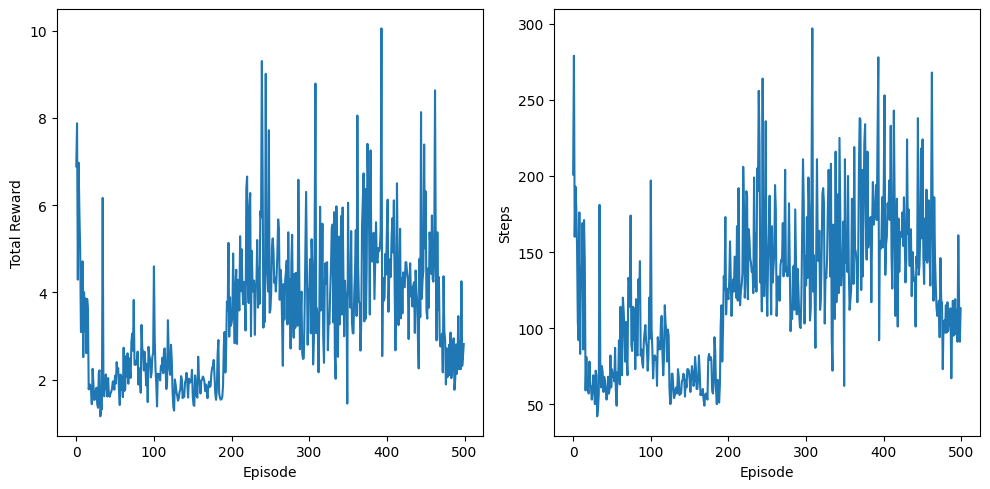

In [86]:
state_dim = 18 #x,y, vx, vy, ax, ay for 3 stars each
action_dim = 6 #x,y 
max_action = 1e-3

# Initialize the agent and the replay buffer
agent = DDPG(state_dim, action_dim, max_action)
replay_buffer = ReplayBuffer()

# Specify the number of time steps to simulate
num_steps = 1000
num_episodes = 500

episode_rewards = []
episode_steps = []

# Iterate over the number of episodes
for episode in range(num_episodes):

    # Reset the state, done flag, and episode reward
    state = reset_environment()
    done = False
    episode_reward = 0

    # Iterate over the maximum length of an episode
    for step in range(num_steps):

        # Select action
        action = agent.select_action(state)

        # Take a step in the environment
        next_state, reward, done = step_environment(state, action)

        # Store the transition in the replay buffer
        replay_buffer.add((state, next_state, action, reward, done))

        # Move to the next state
        state = next_state

        # Update the total episode reward
        episode_reward += reward

        # If the episode is done, break from the loop
        if done:
            
            break

    # Train the agent
    agent.train(replay_buffer, episode)

    # Print the total episode reward
    print('Episode {}: {}, {}'.format(episode, episode_reward, step))

    # Store the total episode reward and steps
    episode_rewards.append(episode_reward)
    episode_steps.append(step)

# Plot the episode rewards
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(range(num_episodes), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# Plot the episode steps
plt.subplot(1, 2, 2)
plt.plot(range(num_episodes), episode_steps)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.tight_layout()
plt.show()


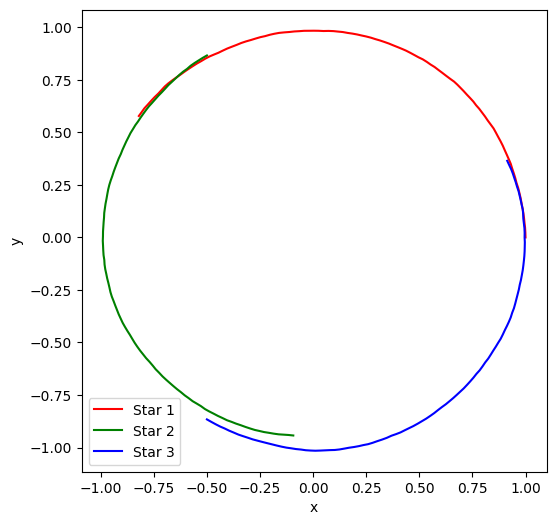

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Reset the state, done flag, and episode reward
state = reset_environment()
done = False

# Initialize array to store positions
positions = np.zeros((num_steps, 3, 2))

# Iterate over the maximum length of an episode
for step in range(num_steps):

    # Store current positions
    positions[step] = state[:6].reshape((2,3)).T

    # Select action
    action = agent.select_action(state)

    # Take a step in the environment
    next_state, reward, done = step_environment(state, action)

    # Move to the next state
    state = next_state

    # If the episode is done, break from the loop
    if done:
        break

positions = positions[:step]
# Plot the trajectories of the stars
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(positions[:,0,0], positions[:,0,1], 'r', label='Star 1')
plt.plot(positions[:,1,0], positions[:,1,1], 'g', label='Star 2')
plt.plot(positions[:,2,0], positions[:,2,1], 'b', label='Star 3')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()
